In [27]:
from chainconsumer import ChainConsumer
import pickle as pk
import numpy as np
import astropy.units as u
from astropy.modeling import models
from scipy.stats import norm, uniform
import matplotlib.pyplot as plt
from IPython.display import display, Math
import pandas as pd
import seaborn as sns

%matplotlib inline


In [28]:
def v0_fixed_log_likelihood(theta, x, y, yerr):
    T_guess, a_guess, beta_guess, log_f = theta
    #T_guess, a_guess, log_f = theta
    y, yerr =  y.value, yerr.value
    model = lambda v: a_guess*(1-np.exp(-(v.value/(3000))**beta_guess))*models.BlackBody(temperature = T_guess*u.K, scale = 1*u.MJy/u.sr)(v).value
    
    #model = lambda v: a_guess*(1-np.exp(-(v.value/3000)**1.95))*models.BlackBody(temperature = T_guess*u.K, scale = 1*u.MJy/u.sr)(v).value
    
    sigma2 = yerr ** 2 + model(x) ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model(x)) ** 2 / sigma2 + np.log(sigma2))

In [29]:
def v0_fixed_log_prior(theta):
    T_guess, a_guess, beta_guess, log_f = theta

    if 0 < T_guess < 200 and 0<a_guess<1 and -5< beta_guess< 10 and -20.0 < log_f < 10.0:
    #if 0 < T_guess < 200 and 0<a_guess<1 and 0<v_0_guess< 100 and -5< beta_guess< 10 -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [30]:
def v0_fixed_log_probability(theta, x, y, yerr):
    lp = v0_fixed_log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    if np.isnan(lp + v0_fixed_log_likelihood(theta, x, y, yerr)):
        print(theta,v0_fixed_log_likelihood(theta, x, y, yerr))
    return lp + v0_fixed_log_likelihood(theta, x, y, yerr)

In [31]:
def model(v, best_fit):
    return best_fit[1]*(1-np.exp(-(v.value/3000)**best_fit[2]))*models.BlackBody(temperature = best_fit[0]*u.K, scale = 1*u.MJy/u.sr)(v).value


In [32]:
def plot(bounds, title):
    fig, ax = plt.subplots()
    plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0, lw=1, label="Data")
    ax.plot(x0, bounds[2, :], label="Best Fit", ls="--"),
    plt.fill_between(x0, bounds[0, :], bounds[-1, :], 
                     label="95% uncertainty", fc="#FFA000", alpha=0.4)
    plt.fill_between(x0, bounds[1, :], bounds[-2, :], 
                     label="68% uncertainty", fc="#D32F2F", alpha=0.2)
    ax.legend()
    ax.set_title('MaDCoWS Stack, grey body temp: '+ title )

    ax.set_xlabel("Frequency (GHz)"), ax.set_ylabel("Surface Brightness (MJy/sr)"), ax.set_xlim(150, 1500), ax.set_ylim(10e-4, 10e-1), ax.set_xscale('log'), ax.set_yscale('log')
    plt.savefig('./plots/herschel/v0_fixed_greybody_for_paper.pdf')
    plt.savefig('./plots/herschel/v0_fixed_greybody_for_paper.png', dpi = 300)


In [36]:
x0 = np.linspace(10, 2000, 100)*u.GHz

x = np.array([1362.69, 250, 350, 500])*u.um
x = x.to(u.GHz, equivalencies=u.spectral())

y = [0.0044044, 0.21843581, 0.16337599, 0.08575974]*u.MJy/u.sr

yerr = np.array([0.0006369, 0.01451, 0.011704, 0.0075511])*u.MJy/u.sr

ndim = 4

In [41]:
sampler = pk.load( open('v0_fixed_sampler.p', 'rb'))

samples = sampler.get_chain()

labels = ['T', 'A', r'\beta', 'f']

best_fit = []
flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = r"$\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    
    if labels[i] == 'T':
        title = txt
    best_fit.append(mcmc[1])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

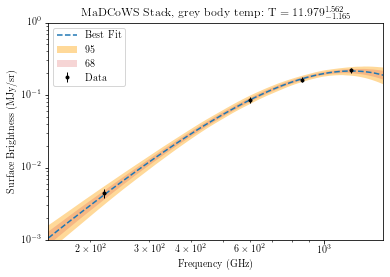

In [42]:

c = ChainConsumer()
chain = sampler.chain[:, 500:, :]
uniform = chain.reshape((-1, ndim))

c.add_chain(uniform, parameters = labels, name="Uniform")


shuffled = np.copy(uniform)
np.random.shuffle(shuffled)
# Row by row construct the prediction of our model using 1000 model realisations
realisations = np.array([model(x0, row[:3]) for row in shuffled[:1000, :]])
bounds = np.percentile(realisations, 100 * norm.cdf([-2, -1, 0, 1, 2]), axis=0)
plot(bounds, title)


(10016, 3)


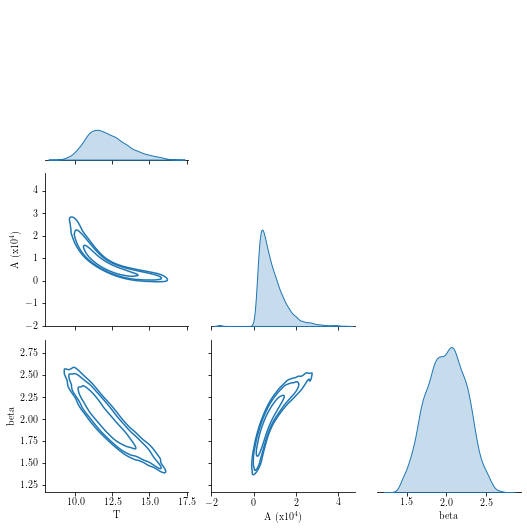

In [84]:
labels = ['T', 'A (x$10^4$)', 'beta', 'f']
flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)
print(flat_samples.T[:cut].T.shape)
cut = 3
df = pd.DataFrame(flat_samples.T[:cut].T, columns = labels[:cut])

df['A (x$10^4$)'] = df['A (x$10^4$)']*10**4

#sns.pairplot(df, corner = True, kind = 'kde')
g = sns.PairGrid(df, corner = True)
g.map_lower(sns.kdeplot, levels = [(1-np.exp(-(1./3.)**2/2.)), (1-np.exp(-(1./2.)**2/2.)), (1-np.exp(-0.5))])
g.map_diag(sns.kdeplot, levels = 2, fill = True)

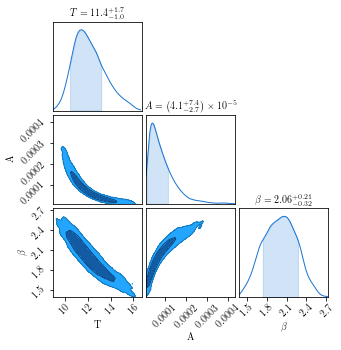

In [97]:
c2 = ChainConsumer()
labels = ['T', 'A', r'$\beta$', 'f']

c2.add_chain(uniform.T[:3].T, parameters = labels[:3], name="Uniform", kde = True)
c2.configure(label_font_size=10)
c2.plotter.plot(filename = 'forpaper.pdf')
plt.savefig('cornerplot_forpaper.png', dpi = 300)
plt.show()

In [54]:
from chainconsumer import ChainConsumer
from scipy.special import erfc
from scipy.stats import norm
import emcee
import numpy as np

np.random.seed(3)
mu, sigma, alpha, num_points = 100, 10, 85, 1000
d_all = np.random.normal(mu, sigma, size=num_points)
d = d_all[d_all > alpha]


def uncorrected_likelihood(xs, data):
    mu, sigma = xs
    if sigma < 0:
        return -np.inf
    return norm(mu, sigma).logpdf(data).sum()

def corrected_likelihood(xs, data):
    mu, sigma = xs
    if sigma < 0:
        return -np.inf
    correction = data.size * np.log(0.5 * erfc((alpha - mu)/(np.sqrt(2) * sigma)))
    return uncorrected_likelihood(xs, data) - correction


ndim = 2
nwalkers = 50
p0 = np.array([95, 0]) + np.random.uniform(low=1, high=10, size=(nwalkers, ndim))
c = ChainConsumer()

functions = [corrected_likelihood, uncorrected_likelihood]
names = ["Corrected Likelihood", "Uncorrected Likelihood"]
for fn, name in zip(functions, names):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, fn, args=[d])
    state = sampler.run_mcmc(p0, 2000)
    chain = sampler.chain[:, 300:, :]
    flat_chain = chain.reshape((-1, ndim))
    c.add_chain(flat_chain, parameters=["$\mu$", "$\sigma$"], name=name)

c.plotter.plot(truth=[mu, sigma], figsize=2.0);


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 432x432 with 4 Axes>

In [63]:
import subprocess
import os 
os.environ["PATH"] += os.pathsep + '/gpfs/fs1/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages'


subprocess.check_call(["latex"])

PermissionError: [Errno 13] Permission denied: 'latex'